# Analysis: CPU sequential train vs. CPU parameter server

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ast

## Sequential AlexNet

In [2]:
def read_model_data(filename):
    info_per_epoch = []
    model_info = {}
    model_info_flag = 1
    with open(filename, 'r') as f:
        for line in f:
            if model_info_flag:
                model_info = ast.literal_eval(line)
                model_info_flag = 0
                continue
            data = ast.literal_eval(line)
            info_per_epoch.append(data)
    f.close()
    model_info['nepochs'] = len(info_per_epoch)
    model_info['mean_time_ep'] = model_info['time'] / model_info['nepochs']
    return info_per_epoch, model_info

In [3]:
a_info_per_epoch, a_model_info = read_model_data("alexnet.txt")

print(a_model_info)
print(len(a_info_per_epoch))
print(a_info_per_epoch[0].keys())

{'time': 19888.87895464897, 'acc': 84.1, 'nepochs': 40, 'mean_time_ep': 497.2219738662243}
40
dict_keys(['epoch', 'epoch_time', 'time_from_start', 'images_per_sec', 'vloss', 'tloss'])


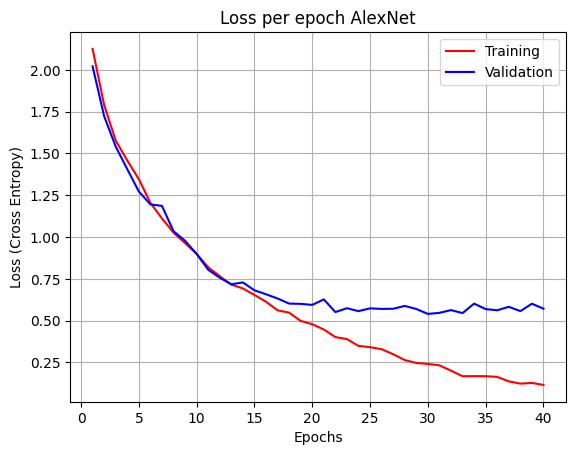

In [4]:
plt.plot([info['epoch'] for info in a_info_per_epoch], [info['tloss'] for info in a_info_per_epoch], '-r',  label='Training')
plt.plot([info['epoch'] for info in a_info_per_epoch], [info['vloss'] for info in a_info_per_epoch], '-b', label='Validation')
plt.title('Loss per epoch AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [5]:
t_img_s = 0

for i in a_info_per_epoch:
    img_s = i['images_per_sec']
    t_img_s += img_s
    
    
print('Mean images per sec trained: {}'.format(t_img_s / len(a_info_per_epoch)))
print('Mean time per epoch: {}'.format(a_model_info['mean_time_ep']))

Mean images per sec trained: 109.00967011981916
Mean time per epoch: 497.2219738662243


## Sequential ResNet

In [6]:
r_info_per_epoch, r_model_info = read_model_data("resnet.txt")

print(r_model_info)
print(len(r_info_per_epoch))
print(r_info_per_epoch[0].keys())

{'time': 24399.222583293915, 'acc': 84.54, 'nepochs': 15, 'mean_time_ep': 1626.614838886261}
15
dict_keys(['epoch', 'epoch_time', 'time_from_start', 'images_per_sec', 'vloss', 'tloss', 'vacc'])


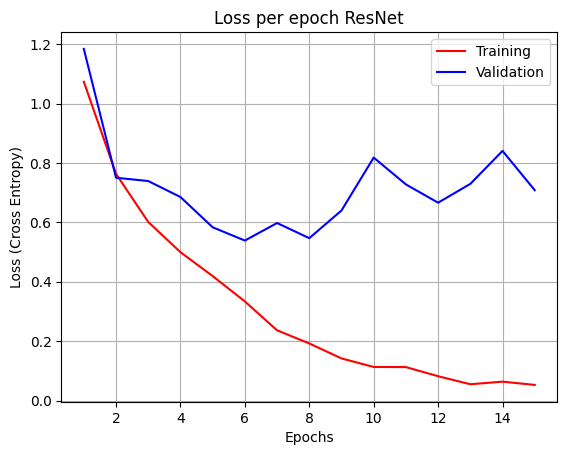

In [7]:
plt.plot([info['epoch'] for info in r_info_per_epoch], [info['tloss'] for info in r_info_per_epoch], '-r',  label='Training')
plt.plot([info['epoch'] for info in r_info_per_epoch], [info['vloss'] for info in r_info_per_epoch], '-b', label='Validation')
plt.title('Loss per epoch ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

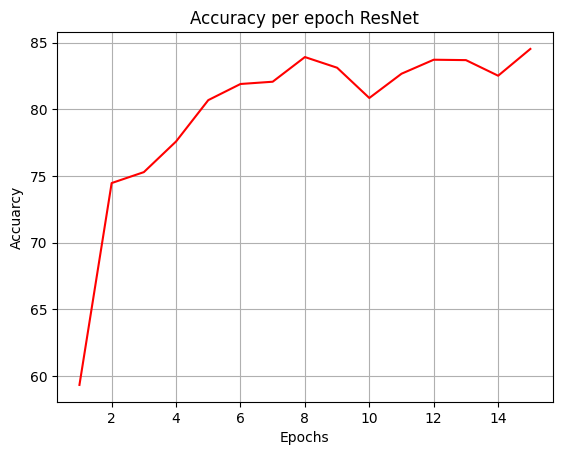

In [8]:
plt.plot([info['epoch'] for info in r_info_per_epoch], [info['vacc'] for info in r_info_per_epoch], '-r')
plt.title('Accuracy per epoch ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.grid(True)
plt.show()

In [9]:
t_img_s = 0

for i in r_info_per_epoch:
    img_s = i['images_per_sec']
    t_img_s += img_s
    
    
print('Mean images per sec trained: {}'.format(t_img_s / len(r_info_per_epoch)))
print('Mean time per epoch: {}'.format(r_model_info['mean_time_ep']))

Mean images per sec trained: 32.23655646014445
Mean time per epoch: 1626.614838886261


## Parameter Server Alexnet

In [10]:
def _read_model_data(filename):
    info_per_epoch = []
    with open(filename, 'r') as f:
        for line in f:
            data = ast.literal_eval(line)
            data['tloss'] /= 10
            info_per_epoch.append(data)
    f.close()
    return info_per_epoch

In [11]:
w0 = _read_model_data("_output0.txt")
w1 = _read_model_data("_output1.txt")
w2 = _read_model_data("_output2.txt")
w3 = _read_model_data("_output3.txt")
w4 = _read_model_data("_output4.txt")


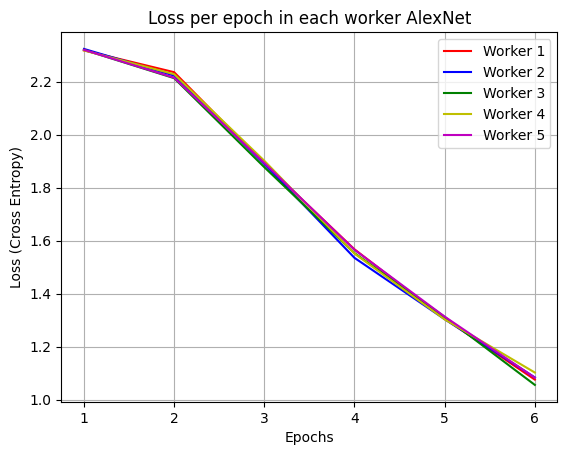

In [12]:
plt.plot([info['epoch'] for info in w0], [info['tloss'] for info in w0], '-r',  label='Worker 1')
plt.plot([info['epoch'] for info in w1], [info['tloss'] for info in w1], '-b', label='Worker 2')
plt.plot([info['epoch'] for info in w2], [info['tloss'] for info in w2], '-g', label='Worker 3')
plt.plot([info['epoch'] for info in w3], [info['tloss'] for info in w3], '-y', label='Worker 4')
plt.plot([info['epoch'] for info in w4], [info['tloss'] for info in w4], '-m', label='Worker 5')
plt.title('Loss per epoch in each worker AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

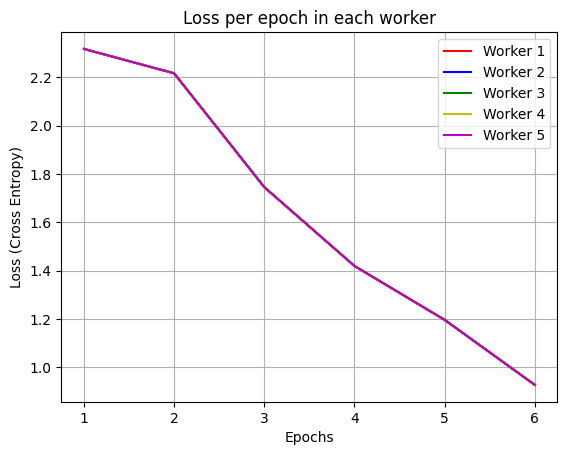

In [13]:
plt.plot([info['epoch'] for info in w0], [info['vloss'] for info in w0], '-r',  label='Worker 1')
plt.plot([info['epoch'] for info in w1], [info['vloss'] for info in w1], '-b', label='Worker 2')
plt.plot([info['epoch'] for info in w2], [info['vloss'] for info in w2], '-g', label='Worker 3')
plt.plot([info['epoch'] for info in w3], [info['vloss'] for info in w3], '-y', label='Worker 4')
plt.plot([info['epoch'] for info in w4], [info['vloss'] for info in w4], '-m', label='Worker 5')
plt.title('Loss per epoch in each worker')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [14]:
def get_mean_time_and_images(arr):
    t_et = 0
    t_img = 0
    for i in arr:
        et = i['epoch_time']
        it = i['images_per_sec']
        t_et += et
        t_img += it
    return t_et / len(arr), t_img / len(arr)

def get_mean(arr):
    t = 0
    for i in arr:
        t += i
    return t / len(arr)

In [15]:
mean_et_w0, mean_it_w0 = get_mean_time_and_images(w0)
mean_et_w1, mean_it_w1 = get_mean_time_and_images(w1)
mean_et_w2, mean_it_w2 = get_mean_time_and_images(w2)
mean_et_w3, mean_it_w3 = get_mean_time_and_images(w3)
mean_et_w4, mean_it_w4 = get_mean_time_and_images(w4)

mean_et_pw = [mean_et_w0, mean_et_w1, mean_et_w2, mean_et_w3, mean_et_w4]
mean_it_pw = [mean_it_w0, mean_it_w1, mean_it_w2, mean_it_w3, mean_it_w4]

print('Mean time per epoch per worker: {}'.format(get_mean(mean_et_pw)))
print('Mean images per sec trained per worker: {}'.format(get_mean(mean_it_pw)))

Mean time per epoch per worker: 6605.445063463846
Mean images per sec trained per worker: 7.5731564926219646


## Parameter Server ResNet

In [16]:
epoch_data_w0 = []
epoch_data_w1 = []
epoch_data_w2 = []
epoch_data_w3 = []
epoch_data_w4 = []

def _read_model_data(filename):
    info_per_epoch = []
    with open(filename, 'r') as f:
        for line in f:
            data = ast.literal_eval(line)
            info_per_epoch.append(data)
    f.close()
    return info_per_epoch

def extract_epoch_data(arr, d):
    for i in arr:
        if (len(i.keys()) > 4):
            d.append(i)
            arr.remove(i)

In [17]:
w0 = _read_model_data("output064resnet.txt")
w1 = _read_model_data("output164resnet.txt")
w2 = _read_model_data("output264resnet.txt")
w3 = _read_model_data("output364resnet.txt")
w4 = _read_model_data("output464resnet.txt")


extract_epoch_data(w0, epoch_data_w0)
extract_epoch_data(w1, epoch_data_w1)
extract_epoch_data(w2, epoch_data_w2)
extract_epoch_data(w3, epoch_data_w3)
extract_epoch_data(w4, epoch_data_w4)

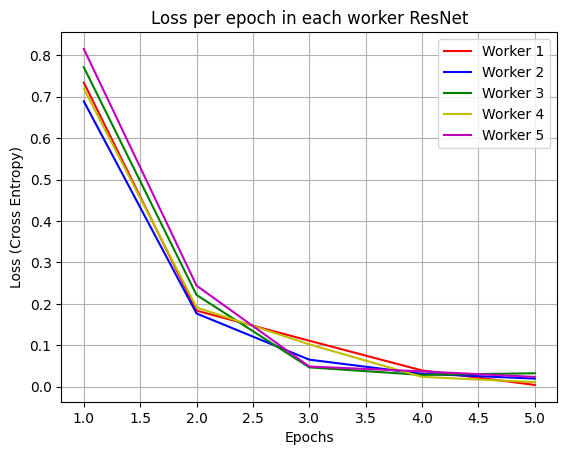

In [18]:
plt.plot([info['epoch'] for info in epoch_data_w0], [info['tloss'] for info in epoch_data_w0], '-r',  label='Worker 1')
plt.plot([info['epoch'] for info in epoch_data_w1], [info['tloss'] for info in epoch_data_w1], '-b', label='Worker 2')
plt.plot([info['epoch'] for info in epoch_data_w2], [info['tloss'] for info in epoch_data_w2], '-g', label='Worker 3')
plt.plot([info['epoch'] for info in epoch_data_w3], [info['tloss'] for info in epoch_data_w3], '-y', label='Worker 4')
plt.plot([info['epoch'] for info in epoch_data_w4], [info['tloss'] for info in epoch_data_w4], '-m', label='Worker 5')
plt.title('Loss per epoch in each worker ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [19]:
mean_et_w0, mean_it_w0 = get_mean_time_and_images(epoch_data_w0)
mean_et_w1, mean_it_w1 = get_mean_time_and_images(epoch_data_w1)
mean_et_w2, mean_it_w2 = get_mean_time_and_images(epoch_data_w2)
mean_et_w3, mean_it_w3 = get_mean_time_and_images(epoch_data_w3)
mean_et_w4, mean_it_w4 = get_mean_time_and_images(epoch_data_w4)

mean_et_pw = [mean_et_w0, mean_et_w1, mean_et_w2, mean_et_w3, mean_et_w4]
mean_it_pw = [mean_it_w0, mean_it_w1, mean_it_w2, mean_it_w3, mean_it_w4]

print('Mean time per epoch per worker: {}'.format(get_mean(mean_et_pw)))
print('Mean images per sec trained per worker: {}'.format(get_mean(mean_it_pw)))

Mean time per epoch per worker: 14687.920290393831
Mean images per sec trained per worker: 3.4047081842473297
